# Vision Transformers for Edge Devices

## Unfolding & Folding images into patches for ViTs

MobileViT core step for rearranging convolution2d activation maps into (B, T, C) format for use with transformers.

The key takeaway here is that rather than merging the patches into the channel dimension i.e `(B, C, H, W) -> (B, (h*w), (pw*ph*C))` to form (B,T,C) for standard ViTs. 

MobileViTs merge the patches into the batch dimension i.e `(B, C, H, W) -> (B*pw*ph, (h*w), C)` to form (B,T,C). This allows each patch to attend to other patches using the `C` data obtained from convolutional layers rather than ViTs which create their `C` data from the raw pixel values. 

**It's a powerful 2 step process where it parallelises the patch to patch attention across the entire batch dimension and allows the model to learn from the convolutional features rather than raw pixel values.**

$$X_{G}(p)=\text{Transformer}(X_{U}(p))$$

Here, the transformer is applied independently for each $p\in\{1,\cdot\cdot\cdot,P\}$. By reshaping to an effective batch size of $B \times P$, standard PyTorch transformer layers can process all $P$ relative pixel locations across all $B$ images entirely in parallel.

In [128]:
import torch
from einops import rearrange

H, W = 128, 128
C = 64
B = 8

x = torch.randn(B, C, H, W)
print(f"Original tensor = {x.shape}")  # (B, C, H, W)

print("---" * 10)

# UNFOLD
# Merge the patches into the batch dimension, and rearrange to (B, T, C) format for use with transformers.
ph, pw = 4, 4
# re-arrange from (B, C, (h ph), (w pw)) -> (B, C, N, P)
tx = rearrange(x, 'b c (h ph) (w pw) -> b c (h w) (ph pw)', ph=ph, pw=pw)
tx = rearrange(tx, 'B C N P -> (B P) N C')  # (B, T, C) where P is the patch size (ph*pw), and N is the number of patches (H//ph * W//pw) and C is the number of channels.
print(f"Unfolded tensor = {tx.shape}")   # (BP, N, C) -> (B*pw*ph, h*w, C) -> (B, T, C)
# NB: For plain ViT, we would just do rearrange(x, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=ph, pw=pw) to get (B, T, C) directly without merging the patch dimension into the batch dimension.


# FOLD
# re-arrange from (BP, N, C) OR (B, T, C) -> (B, C, (h ph), (w pw))
x2 = rearrange(tx, '(b p) (h w) c -> b c (h w) p', h=H//ph, w=W//pw, p=ph*pw)
x2 = rearrange(x2, 'b c (h w) (ph pw) -> b c (h ph) (w pw)', ph=ph, pw=pw, h=H//ph)
print(f"Folded tensor = {x2.shape}")  # (B, C, H, W)

print("---" * 10)

# The above was done for clarity, but we can also do it in one step:
# UNFOLD: Single-step rearrange to (B*P, N, C)
# B*P = b * ph * pw
# N = h * w (where h = H//ph and w = W//pw)
tx = rearrange(x, 'B C (h ph) (w pw) -> (B ph pw) (h w) C', ph=ph, pw=pw)
print(f"Unfolded tensor = {tx.shape}") 

# FOLD: Single-step reverse rearrange back to (B, C, H, W)
x2 = rearrange(tx, '(B ph pw) (h w) C -> B C (h ph) (w pw)', B=B, ph=ph, pw=pw, h=H//ph, w=W//pw)
print(f"Folded tensor = {x2.shape}")

# Sanity check to ensure the math maps perfectly
assert torch.allclose(x, x2), "Folded tensor does not match the original!"

Original tensor = torch.Size([8, 64, 128, 128])
------------------------------
Unfolded tensor = torch.Size([128, 1024, 64])
Folded tensor = torch.Size([8, 64, 128, 128])
------------------------------
Unfolded tensor = torch.Size([128, 1024, 64])
Folded tensor = torch.Size([8, 64, 128, 128])


## Transformers as convolution operators on simple images

![Transformers as convolutions](./images/transformers-as-convolutions.png)

In [129]:
import torch
from einops import rearrange

# 1. Setup dimensions matching the 9x9 illustration
H, W = 9, 9
C = 1  # 1 channel for easy visualization
B = 1  # 1 image in the batch
ph, pw = 3, 3  # 3x3 patches

# 2. Create a tensor where each pixel's value is its flat index (0 to 80)
x = torch.arange(H * W).view(B, C, H, W)

print("Original 9x9 Image (Pixel IDs):")
print(x[0, 0])

Original 9x9 Image (Pixel IDs):
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23, 24, 25, 26],
        [27, 28, 29, 30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49, 50, 51, 52, 53],
        [54, 55, 56, 57, 58, 59, 60, 61, 62],
        [63, 64, 65, 66, 67, 68, 69, 70, 71],
        [72, 73, 74, 75, 76, 77, 78, 79, 80]])


In [130]:
# 3. Unfold operation: (B, C, H, W) -> (B * P, N, C)
# P = ph * pw = 9 (transformer batch size)
# N = (H // ph) * (W // pw) = 9 (transformer sequence length)
tx = rearrange(x, 'b c (h ph) (w pw) -> (b ph pw) (h w) c', ph=ph, pw=pw)

print(f"\nUnfolded Tensor Shape: {tx.shape} -> (Batch=P, Sequence=N, Channels=C)")
print(f"All top-left pixels: {tx[0, :, 0]}")  # Should be [0, 9, 18, 27, 36, 45, 54, 63, 72]
centerPixels = tx[4, :, 0]  # This should correspond to the center pixels of each patch
print(f"All dead-center pixels: {centerPixels}")

# Attention between the dead-center pixels
centerPixels = centerPixels.reshape(-1,1)
deadCenterAttn = centerPixels @ centerPixels.T
print("\nAttention between the dead-center pixels:")
print(deadCenterAttn)


Unfolded Tensor Shape: torch.Size([9, 9, 1]) -> (Batch=P, Sequence=N, Channels=C)
All top-left pixels: tensor([ 0,  3,  6, 27, 30, 33, 54, 57, 60])
All dead-center pixels: tensor([10, 13, 16, 37, 40, 43, 64, 67, 70])

Attention between the dead-center pixels:
tensor([[ 100,  130,  160,  370,  400,  430,  640,  670,  700],
        [ 130,  169,  208,  481,  520,  559,  832,  871,  910],
        [ 160,  208,  256,  592,  640,  688, 1024, 1072, 1120],
        [ 370,  481,  592, 1369, 1480, 1591, 2368, 2479, 2590],
        [ 400,  520,  640, 1480, 1600, 1720, 2560, 2680, 2800],
        [ 430,  559,  688, 1591, 1720, 1849, 2752, 2881, 3010],
        [ 640,  832, 1024, 2368, 2560, 2752, 4096, 4288, 4480],
        [ 670,  871, 1072, 2479, 2680, 2881, 4288, 4489, 4690],
        [ 700,  910, 1120, 2590, 2800, 3010, 4480, 4690, 4900]])


In [131]:
# 5. Verify the original spatial coordinates of this sequence
center_sequence = tx[4, :, 0]  # This should correspond to the center pixels of each patch
print("\nVerifying original coordinates for these pixels:")
for pixel_id in center_sequence:
    row = pixel_id.item() // W
    col = pixel_id.item() % W
    print(f"Pixel ID {pixel_id.item():2d} was originally at -> (Row {row}, Col {col})")


Verifying original coordinates for these pixels:
Pixel ID 10 was originally at -> (Row 1, Col 1)
Pixel ID 13 was originally at -> (Row 1, Col 4)
Pixel ID 16 was originally at -> (Row 1, Col 7)
Pixel ID 37 was originally at -> (Row 4, Col 1)
Pixel ID 40 was originally at -> (Row 4, Col 4)
Pixel ID 43 was originally at -> (Row 4, Col 7)
Pixel ID 64 was originally at -> (Row 7, Col 1)
Pixel ID 67 was originally at -> (Row 7, Col 4)
Pixel ID 70 was originally at -> (Row 7, Col 7)


In [132]:
# Translating this to a B=2
# 1. Setup a small batch: 2 images, 1 channel, 4x4 resolution
B, C, H, W = 2, 1, 4, 4
ph, pw = 2, 2  # 2x2 patches

# P = ph * pw = 4 (pixels per patch)
# N = (H // ph) * (W // pw) = 4 (number of patches)

# 2. Create distinct data for each image to track them easily
img0 = torch.arange(0, 16).view(1, C, H, W)     # Values 0 to 15
img1 = torch.arange(100, 116).view(1, C, H, W)  # Values 100 to 115

x = torch.cat([img0, img1], dim=0)
print(f"mini-batch of 2 images:\t{x.shape}")

# 3. Perform the Unfold operation
# b c (h ph) (w pw) -> (b ph pw) (h w) c
tx = rearrange(x, 'b c (h ph) (w pw) -> (b ph pw) (h w) c', ph=ph, pw=pw)

print(f"Unfolded Shape: {tx.shape} -> (Effective Batch, Sequence N, Channels C)")
print(f"Effective Batch Size = B * P = {B} * {ph*pw} = {B * ph * pw}")

# 4. Extract sequences to prove images do not mix
# The einops rearrange groups by 'b' first, then 'ph', then 'pw'.
# Indices 0 to 3 correspond to Image 0's four relative pixel locations.
# Indices 4 to 7 correspond to Image 1's four relative pixel locations.

# The "top-left" pixel sequence for Image 0 is at effective batch index 0
seq_img0 = tx[0, :, 0]

# The "top-left" pixel sequence for Image 1 is at effective batch index 4
seq_img1 = tx[4, :, 0]

print(f"\nImage 0 'top-left' sequence: {seq_img0.tolist()}")
print(f"Image 1 'top-left' sequence: {seq_img1.tolist()}")

mini-batch of 2 images:	torch.Size([2, 1, 4, 4])
Unfolded Shape: torch.Size([8, 4, 1]) -> (Effective Batch, Sequence N, Channels C)
Effective Batch Size = B * P = 2 * 4 = 8

Image 0 'top-left' sequence: [0, 2, 8, 10]
Image 1 'top-left' sequence: [100, 102, 108, 110]


## Transformers as convolution operators on real images

![Transformers as convolutions](./images/transformers-as-convolutions.png)

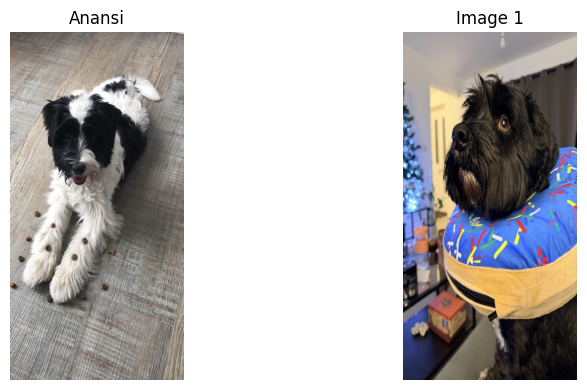

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img0 = Image.open('./images/anansi.jpeg')
img1 = Image.open('./images/veles.jpeg')

W = 400 #min(img0.size[0], img1.size[0])
H = 800 #min(img0.size[1], img1.size[1])

img0 = np.array(img0.resize((W, H), Image.LANCZOS))
img1 = np.array(img1.resize((W, H), Image.LANCZOS))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img0)
axes[0].set_title('Anansi')
axes[0].axis('off')

axes[1].imshow(img1)
axes[1].set_title('Image 1')
axes[1].axis('off')

plt.tight_layout()
plt.show()

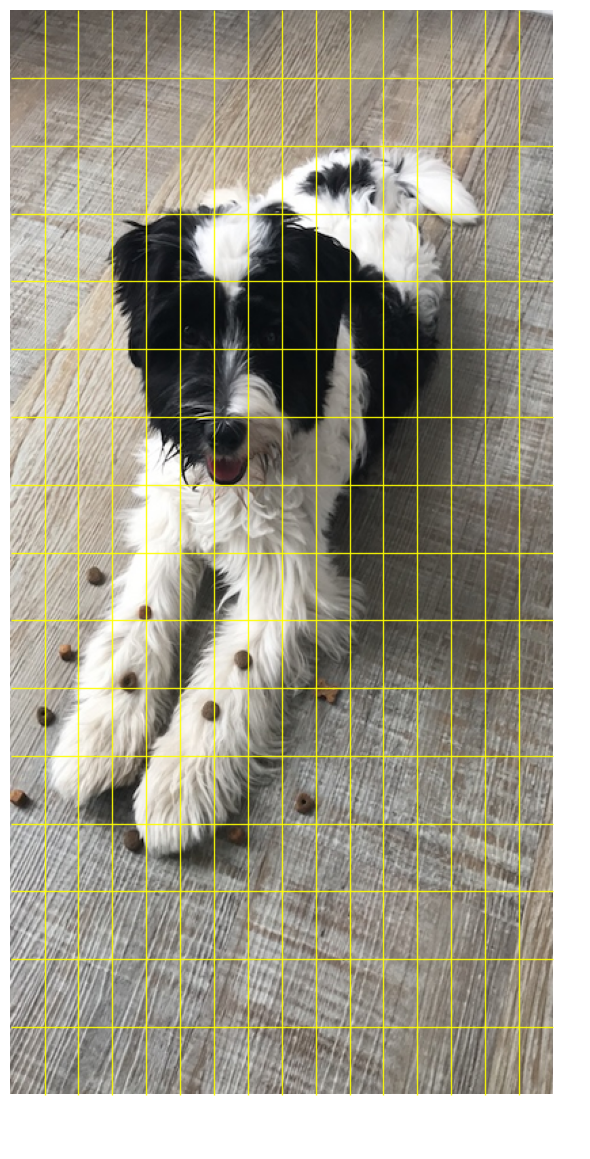

In [154]:
# Unfold operation on Anansi
C = 3
B = 1  # 1 image in the batch
ph, pw = 50, 25

# Visualise what the 8x4 patches look like on Anansi
fig, ax = plt.subplots(figsize=(6, 6 * H / W))
ax.imshow(img0)

# draw vertical and horizontal grid lines every pw and ph pixels
ax.vlines(range(pw, W, pw), ymin=0, ymax=H, colors='yellow', linewidth=1, alpha=0.9)
ax.hlines(range(ph, H, ph), xmin=0, xmax=W, colors='yellow', linewidth=1, alpha=0.9)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [145]:
print(f"Squeeze image from {img0.shape} to (B, H, W, C) format for unfolding into patches")
anansi = np.expand_dims(img0, 0)
unfoldedAnansi = rearrange(anansi, 'B (h ph) (w pw) C -> (B ph pw) (h w) C', ph=ph, pw=pw)
print(f"Unfolded shape: {unfoldedAnansi.shape} -> (Batch=P, Sequence=N, Channels=C)")

Squeeze image from (800, 400, 3) to (B, H, W, C) format for unfolding into patches
Unfolded shape: (1250, 256, 3) -> (Batch=P, Sequence=N, Channels=C)


A single patch $p$ is $50 \times 25 = 1250$. To show all top-left pixels across all patches

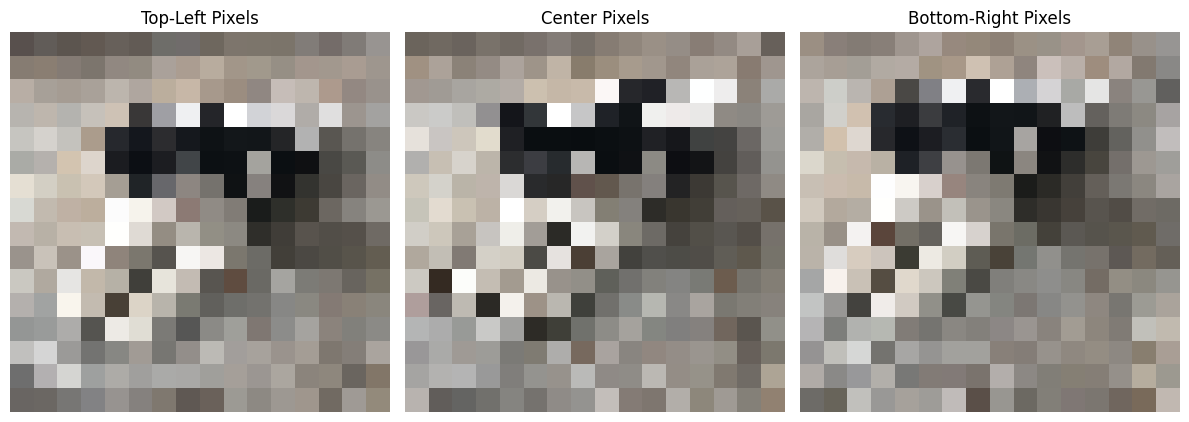

In [143]:
topLeftAnansi = unfoldedAnansi[0, :, :]

centerPixelIdx = unfoldedAnansi.shape[0] // 2
centerPixelAnansi = unfoldedAnansi[centerPixelIdx, :, :]

bottomRightIdx = unfoldedAnansi.shape[0] - 1
bottomRightAnansi = unfoldedAnansi[bottomRightIdx, :, :]

h, w = H // ph, W // pw

topLeftAnansi = topLeftAnansi.reshape(h, w, C)
centerPixelAnansi = centerPixelAnansi.reshape(h, w, C)
bottomRightAnansi = bottomRightAnansi.reshape(h, w, C)

# Tile side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(topLeftAnansi)
axes[0].set_title('Top-Left Pixels')
axes[0].axis('off')

axes[1].imshow(centerPixelAnansi)
axes[1].set_title('Center Pixels')
axes[1].axis('off')

axes[2].imshow(bottomRightAnansi)
axes[2].set_title('Bottom-Right Pixels')
axes[2].axis('off')

plt.tight_layout()
plt.show()

From a single image, we can generate $ph \times pw$ more images from the same image by shifting across each pixel location in a patch across all patches in the image. This is what MobileViT does by merging the patches into the batch dimension.

The transformer layer can process each item in the batch independently (i.e all images from top-left pixels across all patches, to the bottom-right pixels across all patches) and learn to attend to the relevant features across the entire image. Regardless of the pixel location in the patch, the transformer is still looking at the global context of the image (albeit from a slightly different perspective).